# Задание 1

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import samplesize_confint_proportion
from scipy.stats import norm

m = 6
sigma = 2
n_sam = 1000
sam_size = 30
conf = 0.95
alpha = 1-conf

np.random.seed(42)
samples = [np.random.normal(m,sigma,sam_size) for _ in range(n_sam)]

# бутстреп
def boots(data,n_boots=1000):
    boots_means = []
    boots_vars = []
    for _ in range(n_boots):
        resam = np.random.choice(data,size=len(data),replace=True)
        boots_means.append(np.mean(resam))
        boots_vars.append(np.var(resam))
    return (np.percentile(boots_means,[100*alpha/2, 100*(1 - alpha/2)]),
        np.percentile(boots_vars,[100*alpha/2, 100*(1 - alpha/2)]))

# параметрический
def param(data):
    mean = np.mean(data)
    var = np.var(data,ddof=1)
    n = len(data)
    t_crit = stats.t.ppf(1 - alpha/2, n-1)
    chi2_lower = stats.chi2.ppf(alpha/2, n-1)
    chi2_upper = stats.chi2.ppf(1 - alpha/2, n-1)
    mean_ci = (mean - t_crit*np.sqrt(var/n), mean + t_crit*np.sqrt(var/n))
    var_ci = ((n-1)*var/chi2_upper, (n-1)*var/chi2_lower)
    return mean_ci, var_ci

boots_mean_coverage = 0
boots_var_coverage = 0
param_mean_coverage = 0
param_var_coverage = 0

for sample in samples:
# бутстреп
    boot_mean_ci,boot_var_ci = boots(sample)
    if boot_mean_ci[0] <= m <= boot_mean_ci[1]:
        boots_mean_coverage += 1
    if boot_var_ci[0] <= sigma**2 <= boot_var_ci[1]:
        boots_var_coverage += 1   
# параметрический метод
    param_mean_ci,param_var_ci = param(sample)
    if param_mean_ci[0] <= m <= param_mean_ci[1]:
        param_mean_coverage += 1
    if param_var_ci[0] <= sigma**2 <= param_var_ci[1]:
        param_var_coverage += 1

print('Бутстреп:')
print(f'часть накрытий для m = {boots_mean_coverage/n_sam}')
print(f'часть накрытий для σ² = {boots_var_coverage/n_sam}')
print('Параметрический:')
print(f'часть накрытий для m = {param_mean_coverage/n_sam}')
print(f'часть накрытий для σ² = {param_var_coverage/n_sam}')

Бутстреп:
часть накрытий для m = 0.932
часть накрытий для σ² = 0.862
Параметрический:
часть накрытий для m = 0.948
часть накрытий для σ² = 0.953


#### Вывод: Оба метода демонстрируют высокую эффективность для оценки математического ожидания, что подтверждает их взаимозаменяемость для его оценки. Однако в случае с дисперсией параметрический метод немного лучше справляется с её оценкой.

# Задание 2

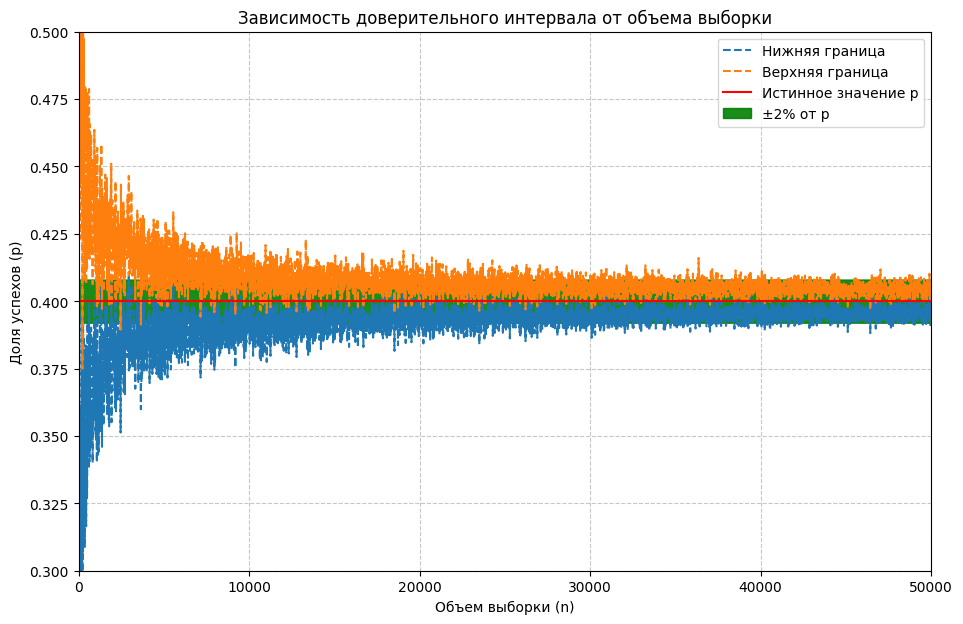

Экспериментальная оценка минимального n: 37810
Теоретическая оценка минимального n: 14405
Оценка минимального n (samplesize_confint_proportion): 14405


In [4]:
p = 0.4
delta = 0.02
conf = 0.95
alpha = 1-conf
z_crit = norm.ppf(1 - alpha/2)

# экспериментальная оценка
np.random.seed(42)
sam_sizes = np.arange(10,50001,10)
lower_b = []
upper_b = []

for n in sam_sizes:
    suc = np.random.binomial(n,p)
    p_hat = suc/n
    m = z_crit*np.sqrt(p_hat*(1-p_hat)/n)
    lower_b.append(p_hat-m)
    upper_b.append(p_hat+m)

plt.figure(figsize=(11,7))
plt.plot(sam_sizes,lower_b,label='Нижняя граница',linestyle='--')
plt.plot(sam_sizes,upper_b,label='Верхняя граница',linestyle='--')
plt.axhline(y=p,color='red',label='Истинное значение p')
plt.fill_between(sam_sizes,p*(1-delta),p*(1+delta),color='green',alpha=0.9,label='±2% от p')
plt.xlabel('Объем выборки (n)')
plt.ylabel('Доля успехов (p)')
plt.title('Зависимость доверительного интервала от объема выборки')
plt.legend()
plt.grid(True,linestyle='--',alpha=0.7)
plt.xlim(0,max(sam_sizes))
plt.ylim(p-0.1,p+0.1) 
plt.show()

# экспериментальная оценка минимального n
exp_n = None
for i, n in enumerate(sam_sizes):
    if i >= 50:
        last_lower = lower_b[i-50:i]
        last_upper = upper_b[i-50:i]
        in_bounds = np.mean([(l >= p*(1-delta)) and (u <= p*(1+delta)) for l, u in zip(last_lower, last_upper)])
        if in_bounds >= 0.95:  
            exp_n = n - 50*10  
            break
print(f'Экспериментальная оценка минимального n: {exp_n}')

# теоретическая оценка
a_delta = p*delta
theor_n = (z_crit/a_delta)**2 * p*(1-p)
print(f'Теоретическая оценка минимального n: {theor_n:.0f}')

# оценка с использованием функции samplesize_confint_proportion
f_n = samplesize_confint_proportion(p,a_delta,alpha=alpha)
print(f'Оценка минимального n (samplesize_confint_proportion): {f_n:.0f}')

#### Вывод: Экспериментальная оценка может быть менее точной при малых объемах выборки, однако при больших объемах выборки она дает более точные результаты. А теоретическая оценка и оценка с использованием функции samplesize_confint_proportion дают хорошее приближение минимально необходимого объема выборки.